# Importing all necessary files

In [1]:
import glob
import os
import librosa
import re
import numpy as np
import math
import AlexNet_arch
librosa.util.MAX_MEM_BLOCK = 262144/4
from torch.autograd import Variable
import torch
import numpy as np
from scipy import misc
from scipy import signal
import torch.optim as optim
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
print(torch.__version__)
import torch.cuda
from sklearn import metrics
import matplotlib.pyplot as plt
import itertools


0.3.1.post2


In [20]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = 100*cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
Labels = ["dog","rooster","pig","cow","frog","cat","hen","insects","sheep","crow"
         "rain","sea_waves","crackling_fire","crickets","chirping_birds","water_drops"
         "wind","pouring_water","toilet_flush","thunderstorm","crying_baby",
         "sneezing","clapping","breathing","coughing","footsteps","laughing",
         "brushing_teeth","snoring","drinking_sipping","door_wood_knock",
         "mouse_click","keyboard_typing","door_wood_creaks","can_opening",
         "washing_machine","vacuum_cleaner","clock_alarm","clock_tick",
         "glass_breaking","helicopter","chainsaw","siren","car_horn",
         "engine","train","church_bells","airplane","fireworks","hand_saw"]


# Initializing an AlexNet instance

In [3]:
audioNet = AlexNet_arch.model()
print(audioNet)

AlexNet(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=12544, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.5)
    (4): Linear(in_feat

# Defining optimizer parameters

In [4]:
criterion = nn.CrossEntropyLoss(size_average=False)
optimizer = torch.optim.SGD(audioNet.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.90)

# Setting frame length and the sampling rate

In [5]:
frameLength = 40 * 1e-3
sr = 16000

In [6]:
dataSetDir = str(sr/1e3) + "KHz_framelength" + str(frameLength*1e3)

In [7]:
print(dataSetDir)

16.0KHz_framelength40.0


In [8]:
def load_spectrogramImages(dataSetDir):
    """
    This function loads the spectogram images from the dataset dir and
    also extracts the labels
    """
    spectograms = []
    names = []
    labels = []
    i = 0
    for file in os.listdir(dataSetDir):
        spectogram = misc.imread(dataSetDir+"//"+file)
        spectograms.append(spectogram)
        names.append(file[:-9])
            
        #extracting the label
        label = re.findall(r'(\d+)(?!.*\d)',file) 
        labels.append(int(label[0]))
        
    return np.array(spectograms),names,np.asarray(labels)

In [9]:
spectograms, names, labels = load_spectrogramImages(dataSetDir)

# Dividing into train and test-set

In [10]:
num = 9*len(spectograms)//10
print("The train-set size is " + str(num))
print("The test-set size is " + str(len(spectograms)- num))

spectTest = []
labelTest = []
for i in range(len(spectograms[num:])):
    labelTest.append(labels[num+i])
    spectTest.append(spectograms[num+i])


The train-set size is 1800
The test-set size is 200


In [11]:
spectograms = torch.from_numpy(spectograms)
spectograms = spectograms.float()
labels = torch.from_numpy(np.asarray(labels))
spectTest = torch.from_numpy(np.asarray(spectTest))
labelTest = torch.from_numpy(np.asarray(labelTest))

In [12]:
print(spectograms[:num].shape)
trainset = torch.utils.data.TensorDataset((spectograms[:num].float()).unsqueeze(1), labels[:num])
testset = torch.utils.data.TensorDataset((spectTest.float()).unsqueeze(1), labelTest)
testData = spectograms[num:].float().unsqueeze(1)


torch.Size([1800, 256, 256])


In [13]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 64,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size = 200)

In [14]:
use_gpu = torch.cuda.is_available()
print(use_gpu)
if use_gpu == True:
    torch.cuda.set_device(4)
    audioNet.cuda()

True


In [15]:
def initializeWeights(layer):
    if isinstance(layer, nn.Conv2d):
        n = layer.kernel_size[0] * layer.kernel_size[1] * layer.out_channels
        layer.weight.data.normal_(0, math.sqrt(2. / n))
    elif isinstance(layer, nn.BatchNorm2d):
        layer.weight.data.fill_(1)
        layer.bias.data.zero_()

In [16]:
audioNet.apply(initializeWeights)

AlexNet(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=12544, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.5)
    (4): Linear(in_feat

In [17]:
for epoch in range(50):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        #inputs = (inputs.float()).unsqueeze(1)
        #print(inputs.shape)
        # wrap them in Variable
        #inputs, labels = Variable(inputs), Variable(labels)
        if use_gpu == True:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            
        else:
            inputs, labels = Variable(inputs), Variable(labels)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = audioNet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.data[0]
        if i % 5 == 4:    # print every 50 mini-batches
            print('[%d, %5d] loss: %.8f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
    scheduler.step()
    correct = 0
    total = 0
    for data in testloader:
        images, labels = data
        if use_gpu == True:
            outputs = audioNet(Variable(images.cuda()))
        else:
            outputs = audioNet(Variable(images))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        if use_gpu == True:
            predicted = predicted.cpu()
        correct += (predicted == labels).sum()
        
    print('Accuracy of the network on the 200 test images: %d %%' % (
        100 * correct / total))
print('Finished Training')

[1,     5] loss: 0.62584127
[1,    10] loss: 0.61919302
[1,    15] loss: 0.61632314
[1,    20] loss: 0.60484746
[1,    25] loss: 0.61286485
Accuracy of the network on the 200 test images: 8 %
[2,     5] loss: 0.58910128
[2,    10] loss: 0.59011167
[2,    15] loss: 0.57484546
[2,    20] loss: 0.57612160
[2,    25] loss: 0.57916730
Accuracy of the network on the 200 test images: 9 %
[3,     5] loss: 0.54430061
[3,    10] loss: 0.56061860
[3,    15] loss: 0.54438718
[3,    20] loss: 0.54397641
[3,    25] loss: 0.55217613
Accuracy of the network on the 200 test images: 9 %
[4,     5] loss: 0.52328696
[4,    10] loss: 0.51692676
[4,    15] loss: 0.55504102
[4,    20] loss: 0.51907529
[4,    25] loss: 0.51073409
Accuracy of the network on the 200 test images: 14 %
[5,     5] loss: 0.49470530
[5,    10] loss: 0.51173338
[5,    15] loss: 0.49300717
[5,    20] loss: 0.49888852
[5,    25] loss: 0.48299654
Accuracy of the network on the 200 test images: 15 %
[6,     5] loss: 0.47867686
[6,    10]

Accuracy of the network on the 200 test images: 50 %
[43,     5] loss: 0.07722152
[43,    10] loss: 0.07844944
[43,    15] loss: 0.09637698
[43,    20] loss: 0.07651669
[43,    25] loss: 0.08198448
Accuracy of the network on the 200 test images: 53 %
[44,     5] loss: 0.07988796
[44,    10] loss: 0.07965796
[44,    15] loss: 0.07747643
[44,    20] loss: 0.08110197
[44,    25] loss: 0.07605704
Accuracy of the network on the 200 test images: 49 %
[45,     5] loss: 0.07917445
[45,    10] loss: 0.07426830
[45,    15] loss: 0.07748255
[45,    20] loss: 0.06618133
[45,    25] loss: 0.08434199
Accuracy of the network on the 200 test images: 52 %
[46,     5] loss: 0.06543729
[46,    10] loss: 0.07388327
[46,    15] loss: 0.07157674
[46,    20] loss: 0.07833137
[46,    25] loss: 0.07520071
Accuracy of the network on the 200 test images: 50 %
[47,     5] loss: 0.07832057
[47,    10] loss: 0.08415887
[47,    15] loss: 0.06986072
[47,    20] loss: 0.06284451
[47,    25] loss: 0.07817434
Accuracy o

In [18]:
print('The final accuracy of the network on the 200 test images after training is: %d %%' % (
        100 * correct / total))

The final accuracy of the network on the 200 test images after training is: 51 %


Confusion matrix, without normalization


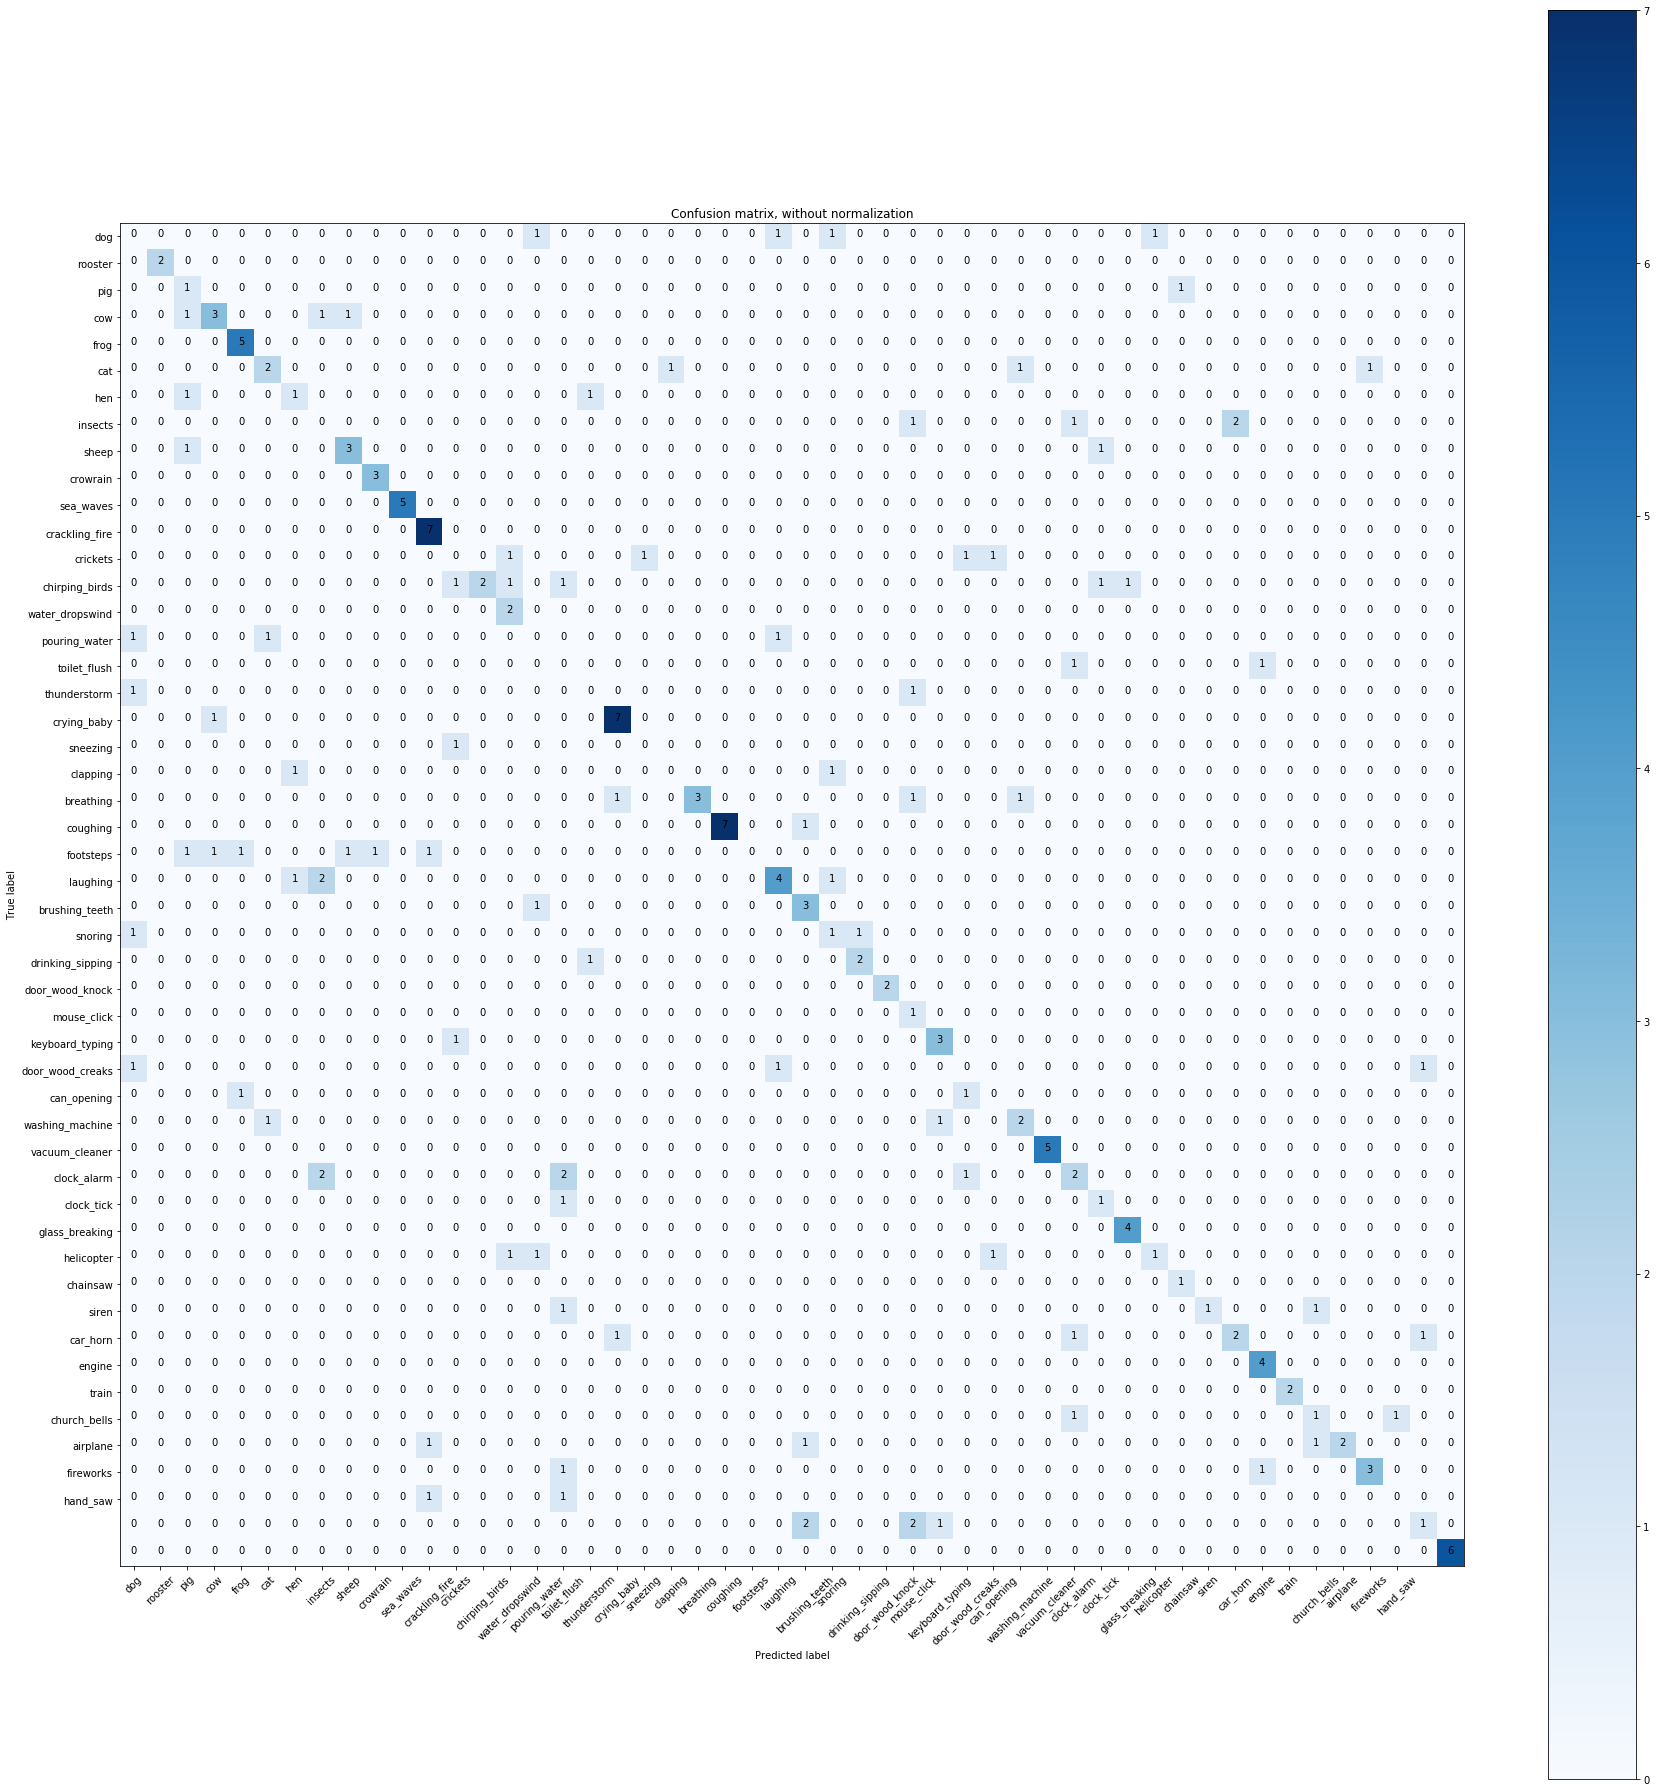

In [21]:
y_pred=np.array([])
y_true=np.array([])
for data in testloader:
        images, labels = data
        #print(labels)
        if use_gpu == True:
            outputs = audioNet(Variable(images.cuda()))
        else:
            outputs = audioNet(Variable(images))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        #print(labels)
        y_true = np.hstack((y_true,labels.numpy()))
        #print("yay")
        if use_gpu == True:
            predicted = predicted.cpu()
        y_pred = np.hstack((y_pred,predicted.numpy()))
        correct += (predicted == labels).sum()
        
#y_pred = y_pred.numpy()
#y_true = np.ndarray(y_true)
#y_pred = np.asarray(y_pred)

cnf_matrix = metrics.confusion_matrix(y_true,y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(25,25))
plot_confusion_matrix(cnf_matrix,classes=Labels,
                      title='Confusion matrix, without normalization')
plt.show()